In [1]:
import numpy as np 
import pandas as pd 
import datetime 
import pickle
import os
import time
import sys
from collections import OrderedDict
from scipy.stats import gamma, lognorm
import textwrap
from datetime import timedelta

import pymc3 as pm
from scipy.linalg import toeplitz
import theano.tensor as tt

%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns

In [32]:
policies

,New York,New Jersey,Michigan,Louisiana,Massachusetts,Illinois,Connecticut,California,Pennsylvania,Florida,Georgia,Washington
Policy,,,,,,,,,,,,
Emergency Declaration,3/7/20,3/9/20,3/10/20,3/11/20,3/10/20,3/9/20,3/10/20,3/4/20,3/6/20,NaN,NaN,NaN
Bar/Restaurant Limits,3/16/20,3/16/20,3/16/20,3/17/20,3/15/20,3/17/20,3/17/20,3/16/20,3/16/20,NaN,NaN,NaN
School Closure,3/18/20,3/18/20,3/16/20,3/16/20,3/15/20,3/17/20,3/17/20,3/15/20,3/13/20,NaN,NaN,NaN
Stay At Home Order,3/20/20,3/21/20,3/24/20,3/22/20,3/24/20,3/20/20,3/23/20,3/19/20,4/1/20,NaN,NaN,NaN
Non-essential Business Closures,3/22/20,3/21/20,3/24/20,3/22/20,3/24/20,3/20/20,3/24/20,3/19/20,3/22/20,NaN,NaN,NaN
Gatherings Ban 500 Or Stricter,3/12/20,NaN,NaN,NaN,NaN,NaN,3/12/20,NaN,NaN,NaN,NaN,NaN
Gatherings Ban 50 Or Stricter,3/16/20,3/16/20,3/17/20,3/17/20,3/15/20,3/18/20,3/16/20,NaN,NaN,NaN,NaN,NaN
Gatherings Ban 10 Or Any Size,3/20/20,3/21/20,3/24/20,3/22/20,3/23/20,3/20/20,3/26/20,3/16/20,NaN,NaN,NaN,NaN


In [2]:
########################################
###        HELPER FUNCTIONS      #######
########################################
def simple_smoother( s, window_size = 5):
    
    neg_idxs = [ i for i in range(len(s)) if s.iloc[i] < 0 ]
    if not neg_idxs:
        return s, False
    else:
        for i in neg_idxs:
            var_later = np.std(s.iloc[i+1:i+1+window_size].values )/ np.mean(s.iloc[i+1:i+1+window_size].values )
            var_earlier = np.std(s.iloc[i-window_size:i].values )/  np.mean(s.iloc[i-window_size:i].values )
            if var_later > var_earlier:  
                interval = (i, i+window_size+1) 
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]+1:interval[1]] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]+1:interval[1]]/(s.iloc[interval[0]+1:interval[1]].sum() ) )
            else:
                interval = (i - window_size, i+1 )
                tot = s.iloc[interval[0]: interval[1]].sum()
                s.iloc[i] = tot/ (window_size + 1)
                s.iloc[interval[0]:interval[1]-1] =(window_size/(window_size+1))*tot*( 
                                                        s.iloc[interval[0]:interval[1]-1]/(s.iloc[interval[0]:interval[1]-1].sum() ) )
        return s.astype(int), True
    

In [4]:
JHU_deaths = load_JHU_deaths()
policies = pd.read_csv("./RoZeroTools/data/state_policy.csv" ,  header =0, index_col = 0) 

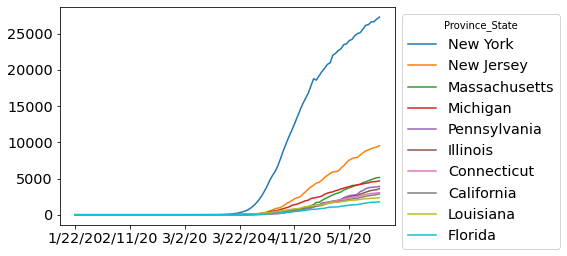

In [5]:
state_top_cas = list(JHU_deaths.iloc[:,-1].sort_values()[::-1].index[0:10])

ax = JHU_deaths.loc[state_top_cas, : ].transpose().plot()
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )

In [6]:
deaths_by_day = pd.DataFrame( index = pd.to_datetime(JHU_deaths.columns[1:]), columns = state_top_cas)
is_smoothed = pd.Series(index =state_top_cas, data = False, dtype = bool )

for state in state_top_cas:
    deaths_by_day_state =  JHU_deaths.loc[state,:].diff().dropna()
    deaths_by_day_state_smooth, smoothed = simple_smoother( deaths_by_day_state.copy(), window_size = 7)
    deaths_by_day.loc[:, state] = deaths_by_day_state_smooth.values
    is_smoothed.loc[state] = smoothed
display(is_smoothed)

New York          True
New Jersey       False
Massachusetts    False
Michigan         False
Pennsylvania     False
Illinois         False
Connecticut      False
California        True
Louisiana        False
Florida          False
dtype: bool

Text(0, 0.5, 'Deaths by day\n(scaled by maximum)')

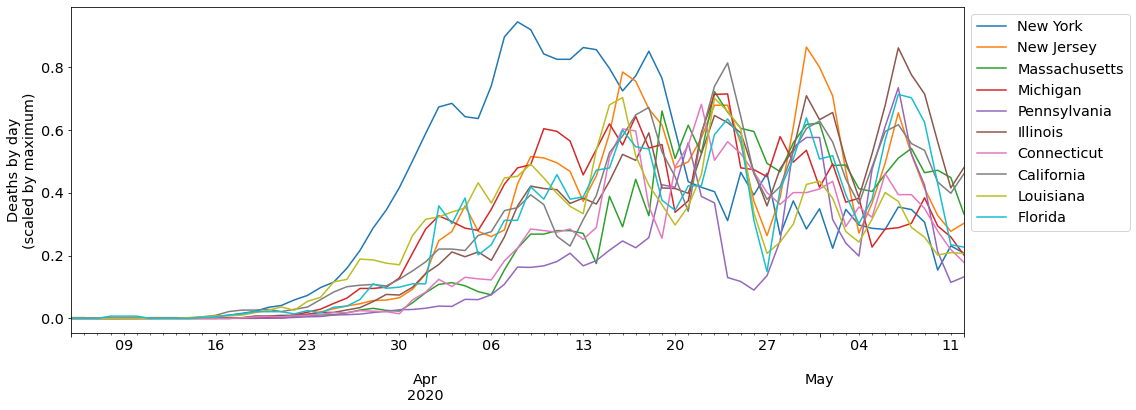

In [7]:
fig , ax = plt.subplots(figsize= (16,6))
ax = deaths_by_day.divide(deaths_by_day.max(axis = 0), axis = 1).rolling(3,).mean().loc['2020-03-05':].plot(ax = ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor( (1, 1), )
ax.set_ylabel("Deaths by day\n(scaled by maximum)")

In [8]:
## Parameters
T_period = (1,8)
draws =  500
chains = 2
mu = 13.
policy_factor = 0.01

## Set up directories for storing ouput
time = datetime.datetime.isoformat(datetime.datetime.now() ).split(".")[0]
models_dir = os.path.join( "models", str(time) )
preds_dir = os.path.join( "predictions", str(time) )

os.makedirs(models_dir , exist_ok = True)
os.makedirs(preds_dir, exist_ok = True)

## Do estimation and write results
for state in state_top_cas:
    print("Working on {}".format(state))
    policy_dates =   [x for x in policies[state].dropna().unique() ]
    ise = Infection_Series_Estimator(event_series =deaths_by_day[state].copy().astype(int), 
                                     P_e_given_i= make_infect_to_death_pmf(), 
                                     T_period = T_period,
                                     policy_dates= policy_dates )
    p_i, Re, p_i_samples, Re_samples= ise.fit(mu = mu,
                                              policy_factor = policy_factor, 
                                              draws = draws ,
                                              chains = chains )
    
    df_samples = pd.concat( [p_i_samples ,Re_samples], axis = 1, keys = ["p_i", "Re"] )
    df_samples.to_csv( os.path.join(preds_dir , "{}_samples.csv".format(state)) )
    df_cinterval =  pd.concat( [p_i , Re] , axis = 1, keys = ["p_i", "Re"] )
    df_cinterval.to_csv( os.path.join(preds_dir , "{}_intervals.csv".format(state)) )
    
    f = open(os.path.join(models_dir, "{}.pkl".format(state)) , 'wb' )
    pickle.dump(ise , f)
    f.close()
    
##  Combine results
df_samples_list = [ pd.read_csv( os.path.join(preds_dir,"{}_samples.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_samples = pd.concat(df_samples_list, axis = 1, keys = list(state_top_cas ) )
df_samples.index = pd.to_datetime(df_samples.index)
df_samples.to_csv( os.path.join(preds_dir,"samples.csv" ) )
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_samples.csv".format(state)) )
    
df_cintervals_list = [ pd.read_csv( os.path.join(preds_dir,"{}_intervals.csv".format(state)), index_col=0 , header = [0,1] ) 
                                    for state in list(state_top_cas )  ]
df_cintervals = pd.concat(df_cintervals_list, axis = 1, keys = list(state_top_cas) )
df_cintervals.to_csv(os.path.join(preds_dir,"intervals.csv" ) )
df_cintervals.index = pd.to_datetime(df_cintervals.index)
for state in state_top_cas:
    os.remove(os.path.join(preds_dir,"{}_intervals.csv".format(state)) )

Working on New York


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 90.13it/s]


Working on New Jersey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:10<00:00, 94.78it/s]


Working on Massachusetts


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:08<00:00, 114.52it/s]


Working on Michigan


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 89.72it/s]


Working on Pennsylvania


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:10<00:00, 94.25it/s]


Working on Illinois


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 100.18it/s]


Working on Connecticut


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:09<00:00, 101.57it/s]


Working on California


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 85.56it/s]


Working on Louisiana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 89.11it/s]


Working on Florida


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_i]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:12<00:00, 81.54it/s]


## Check fits to casualties-by-day data

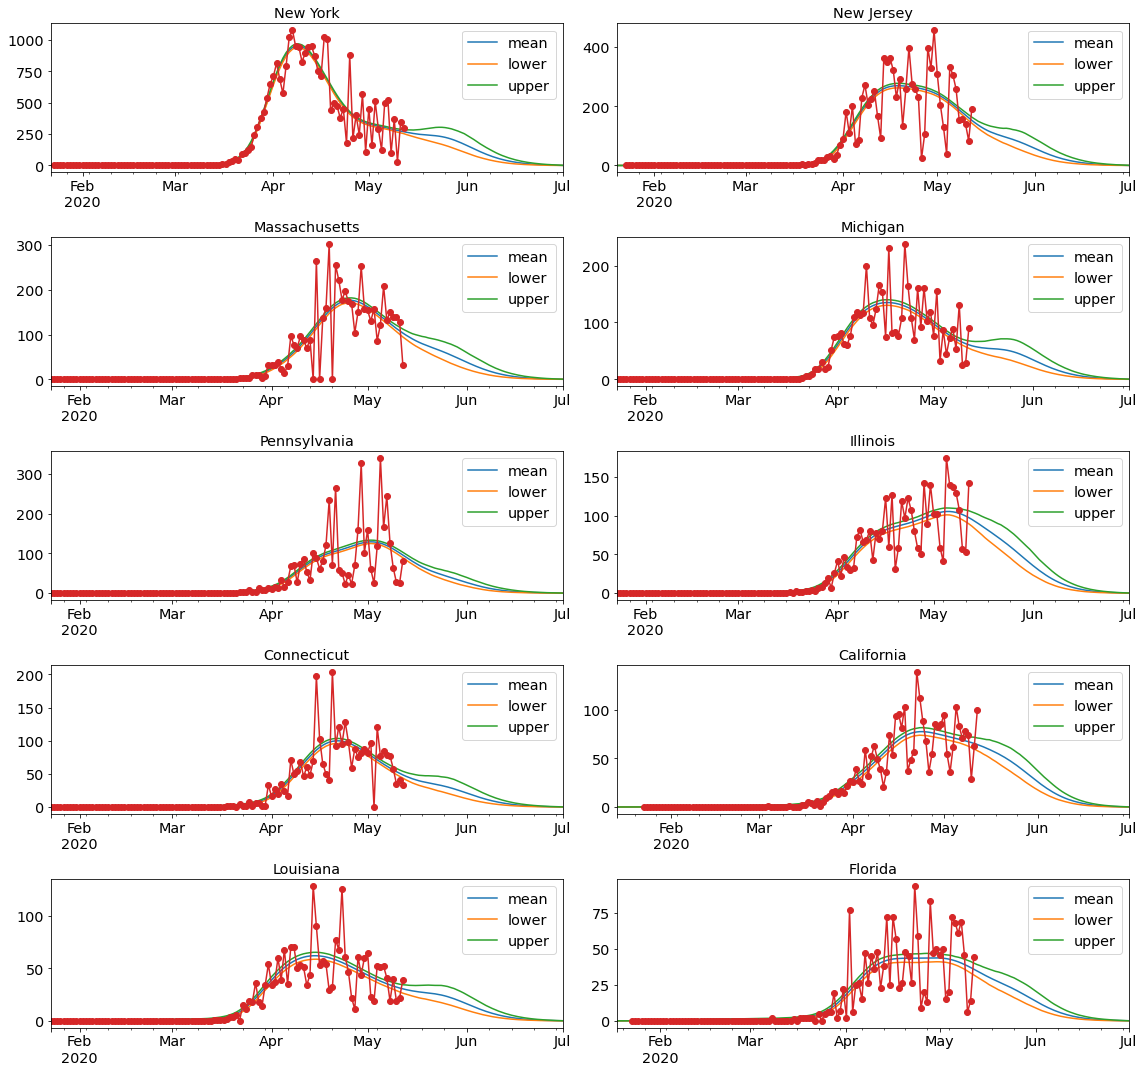

In [18]:
ncols = 2
models_dir = "./models/2020-05-13T17:00:44/"
nrows = -(-len(state_top_cas)//2)


fig , axes = plt.subplots(nrows = nrows, ncols = ncols ,figsize = (16,3*nrows))
axes = np.ravel(axes)

for state, ax in zip(state_top_cas, axes) :
    f = open( os.path.join(models_dir, "{}.pkl".format(state) ) , 'rb')
    ise = pickle.load(f)
    f.close()
    (ise.predict_p_e()[2]).plot(ax = ax)
    deaths_by_day[state].plot(marker = "o", ax = ax)
    ax.set_title(state)
    
fig.tight_layout()

## Plot fraction of total infections by day and $R_e$, the effective reproduction number

In [19]:
## Load data
preditions_dir = "./predictions/2020-05-13T17:00:44/"  ## Change this to match the folder created during execution of estimation cell 
df_cintervals = pd.read_csv(os.path.join(preditions_dir, "intervals.csv"), header = [0,1,2], index_col = 0)

Text(0, 0.5, '$R_e$')

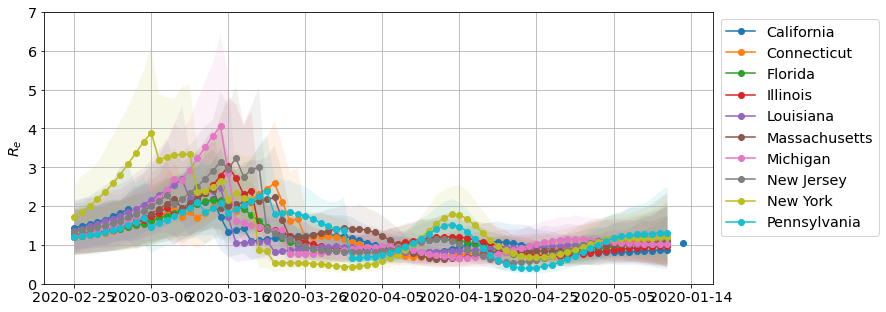

In [20]:
fig = plot_shaded(df_cintervals.loc[ '2020-02-25': ,(slice(None), "Re") ].droplevel(axis = 1,level =1), alpha = 0.1)
ax = fig.get_axes()[0]
ax.set_ylim((0 , 7) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel(r'$R_e$')

Text(0, 0.5, 'Fraction infected on each day')

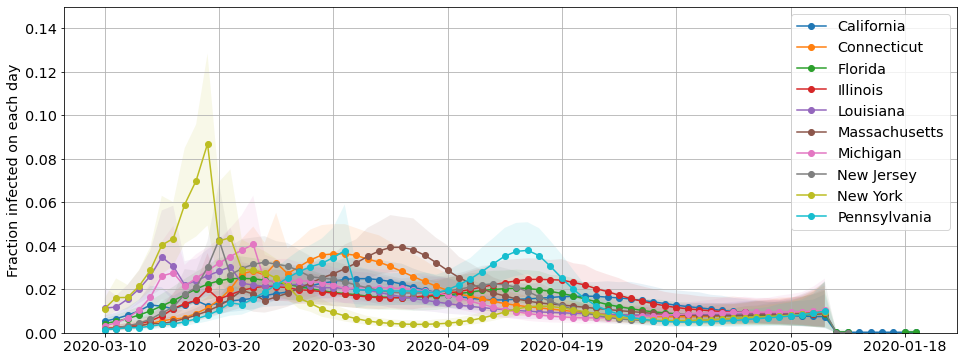

In [21]:
fig = plot_shaded(df_cintervals.loc[ '2020-03-10': ,(slice(None), "p_i") ].droplevel(axis = 1,level =1),
                                           alpha = 0.1,figsize = (16,6))
ax = fig.get_axes()[0]
ax.set_ylim((0 , 0.15) )
ax.grid(True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))
ax.set_ylabel('Fraction infected on each day')

In [28]:
## File names
preditions_dir = "./predictions/2020-05-13T12:44:16/" ## Change this to match the folder created during execution of estimation cell 
fname_policies = "./RoZeroTools/data/state_policy.csv"

## Load Data
df_samples = pd.read_csv( os.path.join(preditions_dir, "samples.csv"), index_col = 0, header=[0,1,2] )
df_samples.index = [pd.Timestamp(x) for x in df_samples.index]
ro_samples = df_samples.loc[ : , (slice(None), "Re")].copy().droplevel(axis=1,  level = 1)
ro_samples_grouped = ro_samples.groupby(axis = 1, level = 0 )
policies = pd.read_csv(fname_policies ,  header =0, index_col = 0)

## Create policy_stats object
policy_stats = Policy_Stats(policies)
pct_change_interval, pct_change_samples = policy_stats.est_pct_change( 
                                                {state:  df.droplevel(axis =1 , level = 0) for state, df in ro_samples_grouped}, 
                                                policies =None)

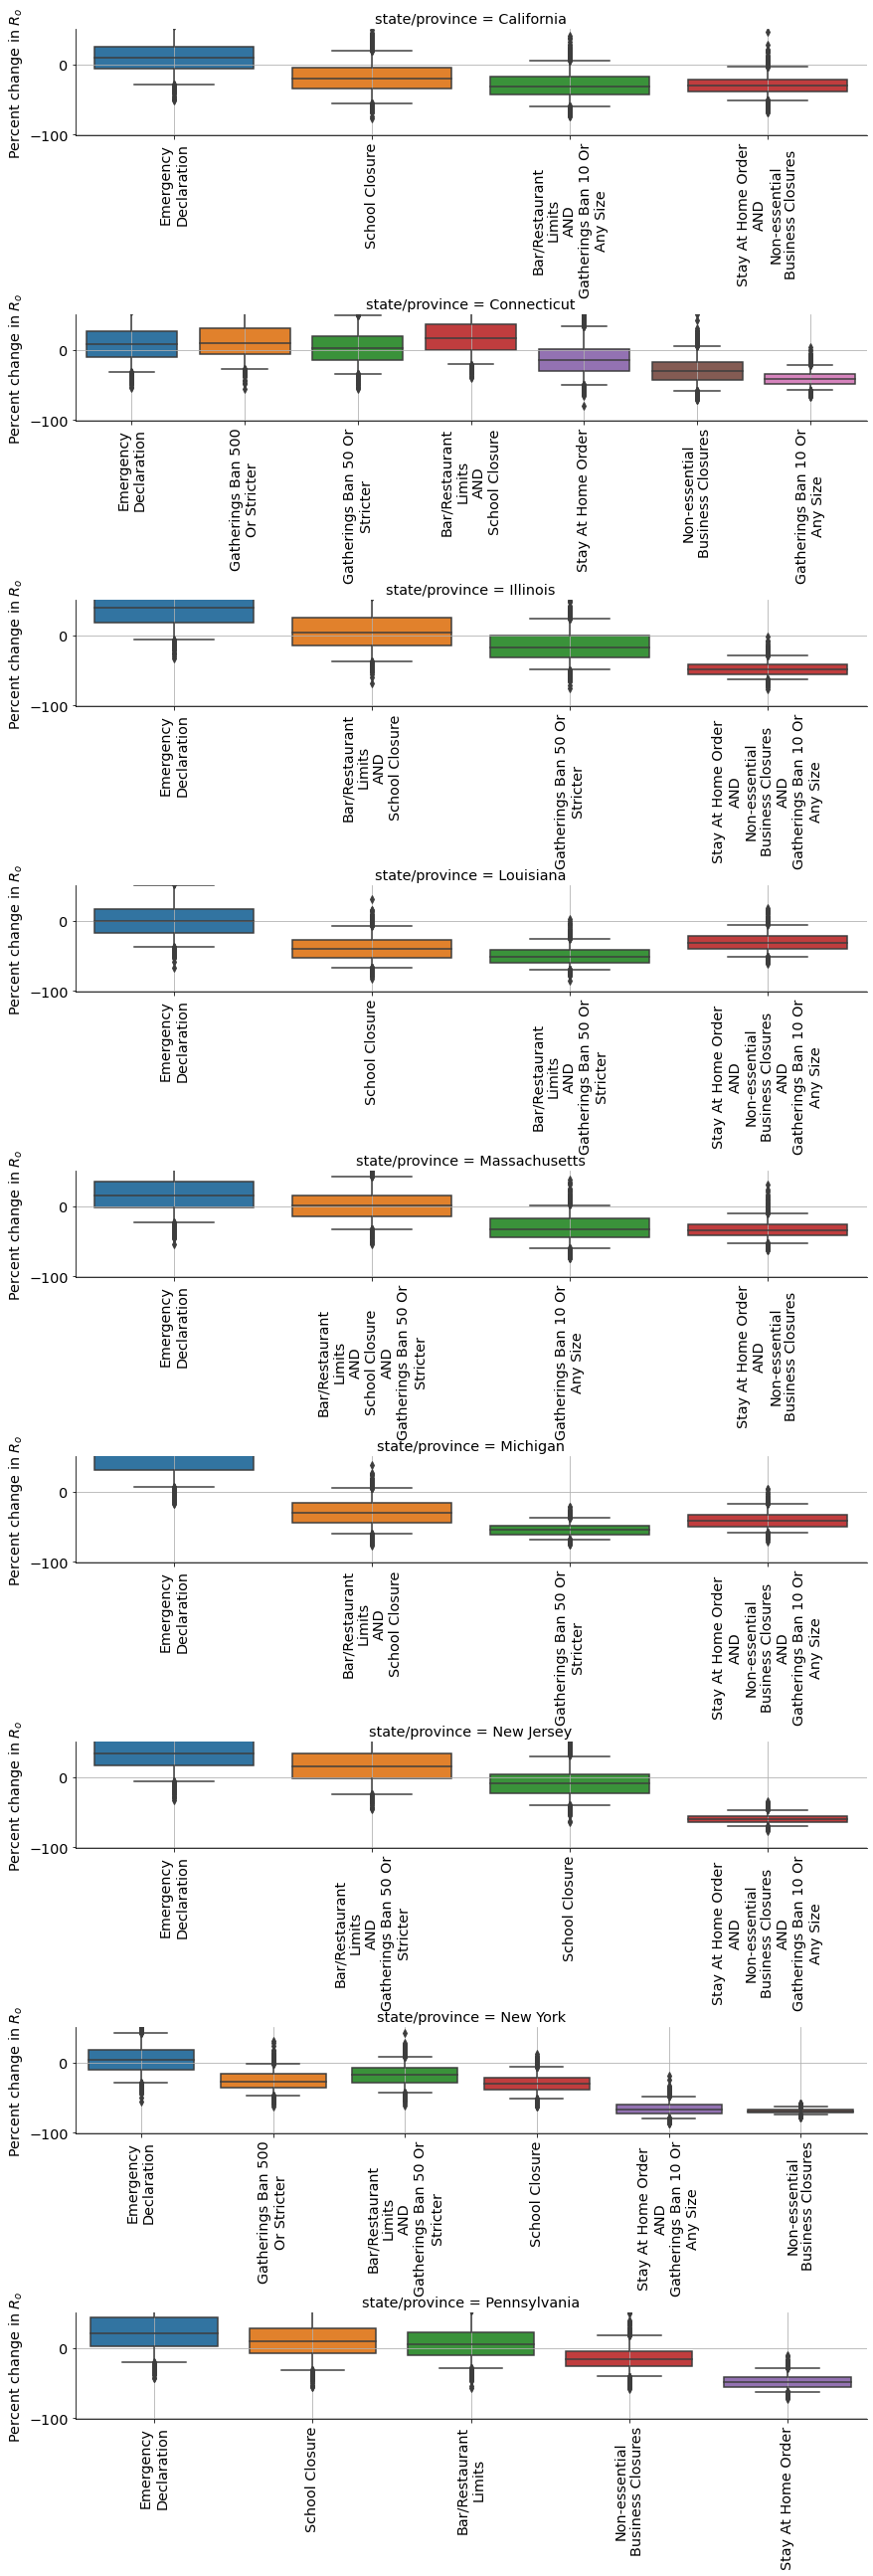

In [29]:
## Plot changes in Ro grouped by state
fig = policy_stats.boxplot_changes_by_state(policies =None, aspect = 3, height = 4, hspace=1.7)

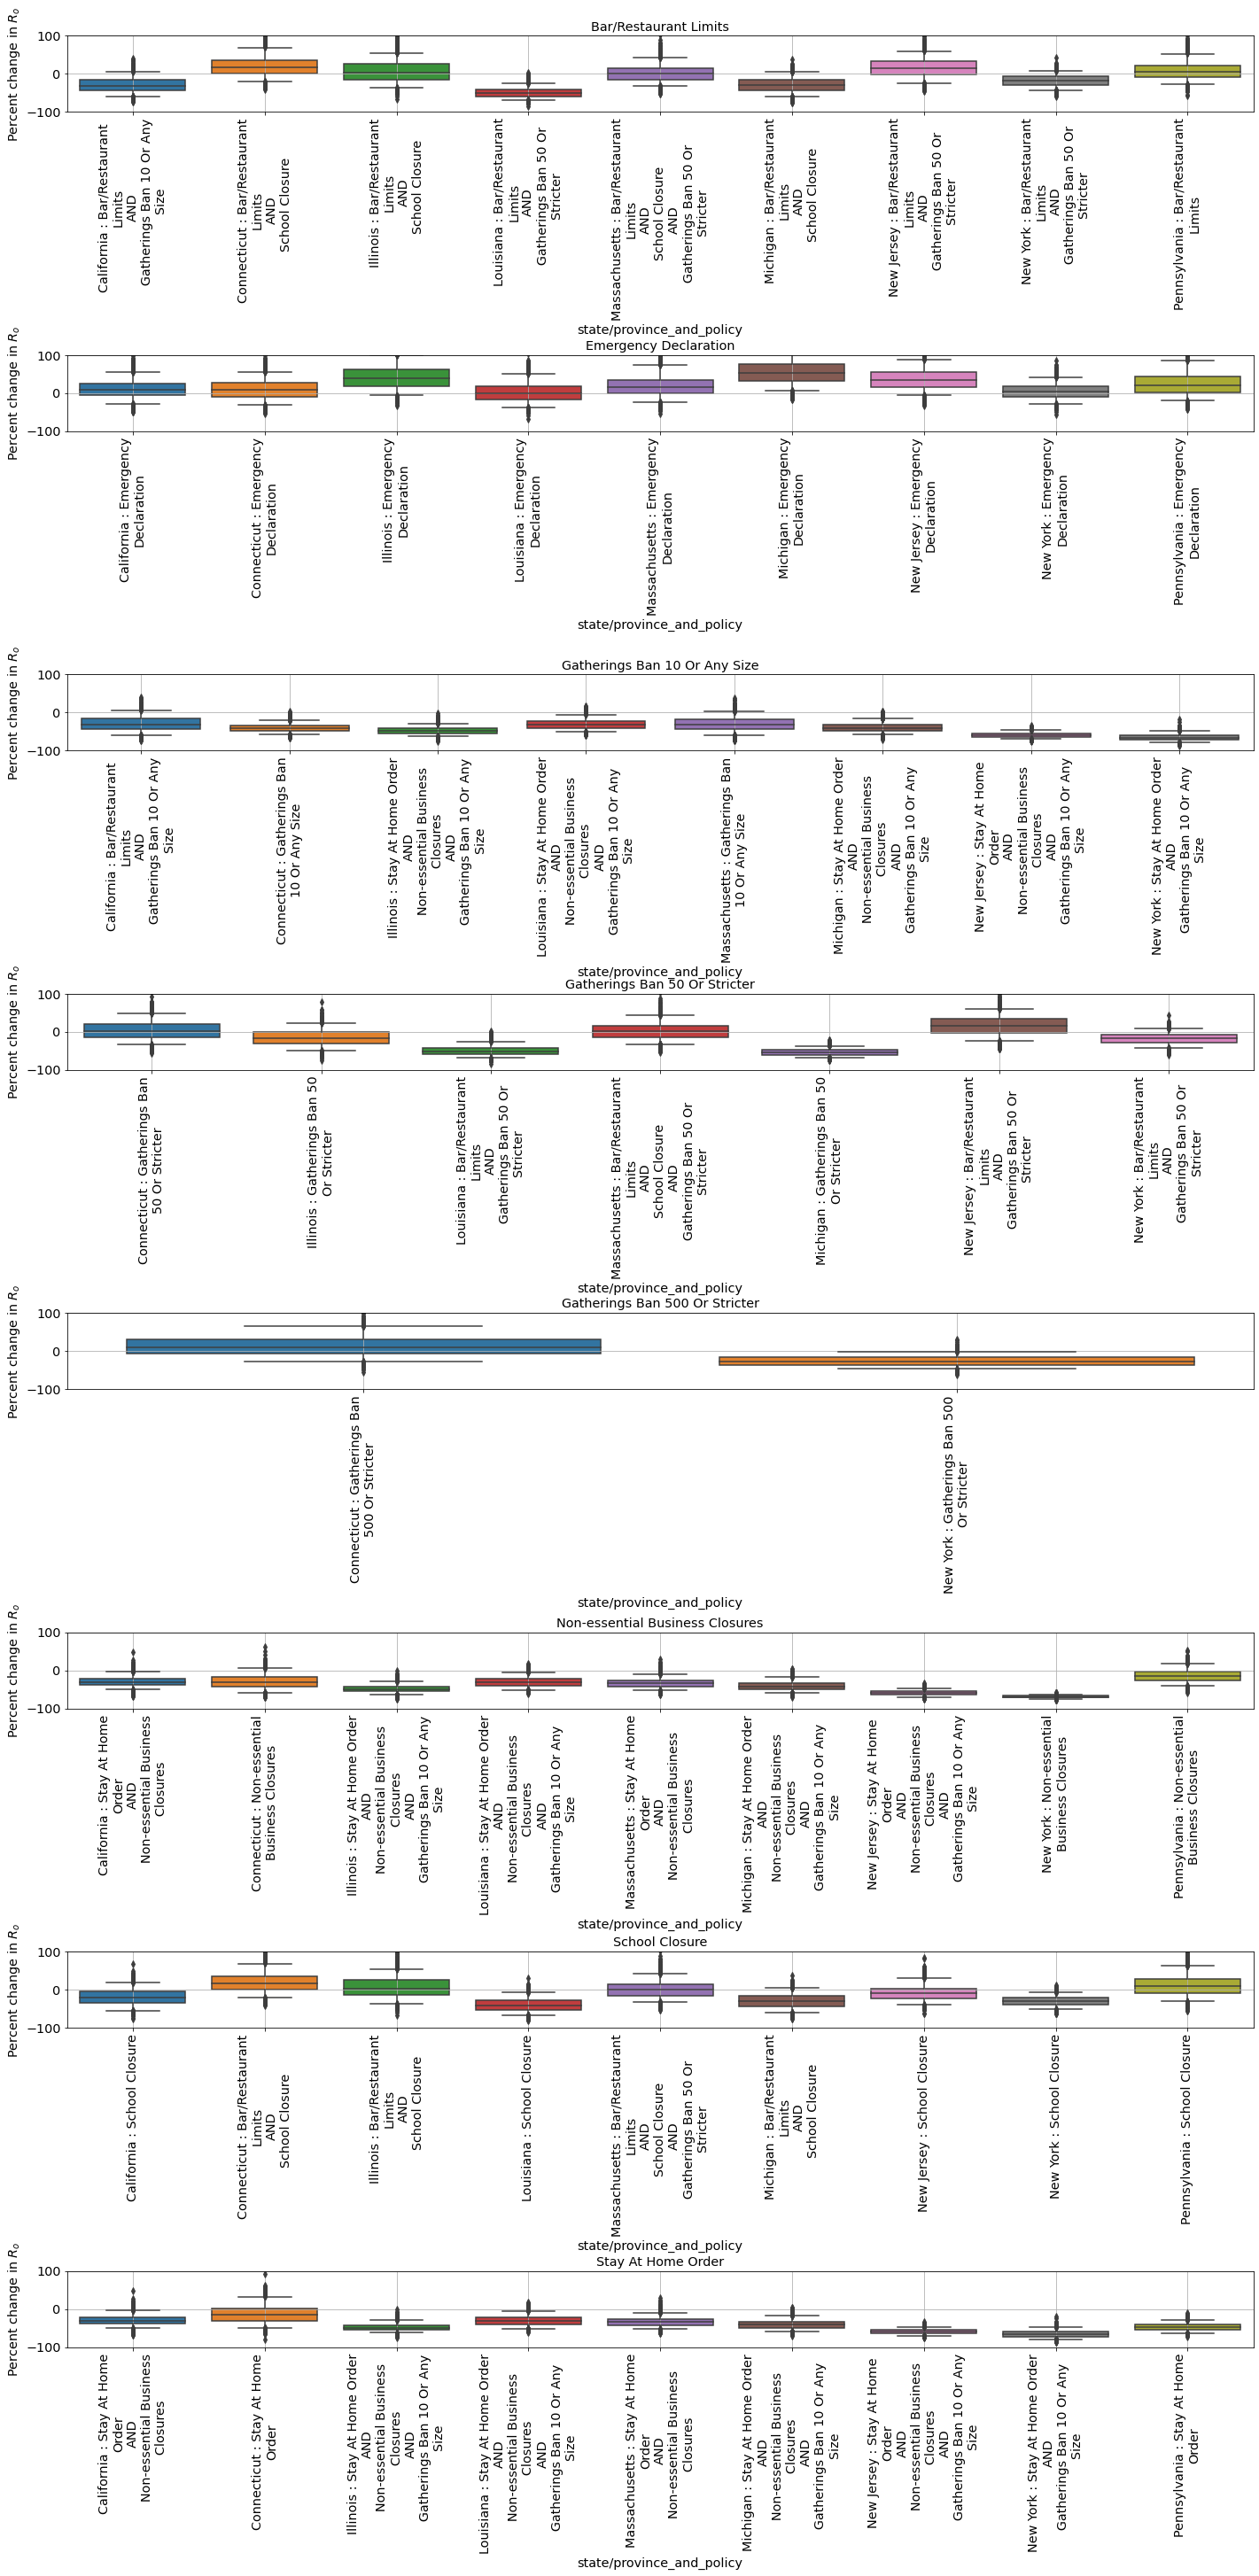

In [30]:
## Plot changes in Ro groups by policy
fig = policy_stats.boxplot_changes_by_policy(aspect = 4, height = 6,y_lim = (-100, 100), hspace = 3.2)